In [1]:
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformation
import data_filter as dafi
import estimate_height as esth

from scipy import signal

WAVELENTH_S1 = 0.1905 # meter


In [2]:
# setting 1004 on the corner Esslingen
main_path = os.path.abspath('../data/20221004/2/')
time_split_length = 1800
azimut_mask = [300,330]
elevation_mask = [0,25]

In [3]:
data_dict = dafi.generate_dataframe(main_path)
satellite_list = data_dict.keys()
for satellite_code in satellite_list:
    data_dict[satellite_code] = dafi.azimut_filter(data_dict[satellite_code],azimut_mask)
    data_dict[satellite_code] = dafi.elevation_filter(data_dict[satellite_code],elevation_mask)

In [4]:
satellite_list

dict_keys(['G01', 'G03', 'G04', 'G08', 'G17', 'G21', 'G22', 'G32', 'G19', 'G31', 'R06', 'R07', 'R08', 'R21', 'R23', 'E07', 'E08', 'E26', 'E33', 'E12', 'E19', 'R24', 'G09', 'R01', 'G06', 'E10', 'R09', 'R10', 'R17', 'G11'])

In [5]:
satellite_code = 'G06'
dataframe = data_dict[satellite_code]
print(dataframe)

                          time   azimut  elevation   snr1   snr2
0    2022-10-04 09:03:40+00:00  305.395      0.002    NaN    NaN
1    2022-10-04 09:03:41+00:00  305.397      0.008    NaN    NaN
2    2022-10-04 09:03:42+00:00  305.400      0.014    NaN    NaN
3    2022-10-04 09:03:43+00:00  305.403      0.020    NaN    NaN
4    2022-10-04 09:03:44+00:00  305.405      0.026    NaN    NaN
...                        ...      ...        ...    ...    ...
3839 2022-10-04 10:07:39+00:00  310.877     24.972  44.50  44.10
3840 2022-10-04 10:07:40+00:00  310.877     24.979  44.40  44.85
3841 2022-10-04 10:07:41+00:00  310.877     24.986  44.55  44.40
3842 2022-10-04 10:07:42+00:00  310.877     24.992  44.70  44.60
3843 2022-10-04 10:07:43+00:00  310.876     24.999  44.65  44.65

[3844 rows x 5 columns]


In [6]:
dataframe_sort = dataframe.sort_values(by='elevation')
snr1_db = np.array(dataframe_sort['snr1'])

In [7]:
def eliminate_longterm_with_least_square(elevation_filtered,snr_filtered):
    # calculate the snr_ref
    design_matrix = np.concatenate((elevation_filtered**2,elevation_filtered,\
                np.ones((elevation_filtered.size,1))),axis=1)
    try:
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                    design_matrix.T),snr_filtered)
    except:
        snr_ref=np.array([])
    else:
        snr_ref = snr_filtered - (elevation_filtered**2 * para[0,0] + \
                    para[1,0]*elevation_filtered + para[2,0])
    return snr_ref

In [8]:
elevation_sort = np.array(dataframe_sort['elevation'])
non_nan_index = ~np.isnan(snr1_db)

elevation_filtered = elevation_sort[non_nan_index]
elevation_filtered = elevation_filtered.reshape(elevation_filtered.size,1)
snr1_filtered = snr1_db[non_nan_index]
snr1_filtered = snr1_filtered.reshape(snr1_filtered.size,1)


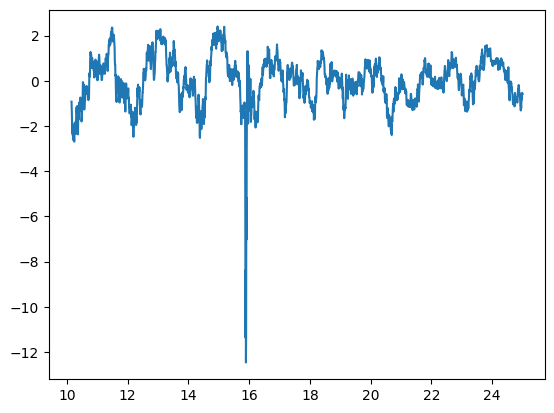

In [13]:
snr1_ref = eliminate_longterm_with_least_square(elevation_filtered,snr1_filtered)
plt.plot(elevation_filtered,snr1_ref)

[ 0.53187319  1.07917792  1.48915892  1.90113011  2.66934693  3.16490649
  4.00875088  4.57794779  5.1769977   5.68250825  6.14821482  6.65571557
  7.18709871  7.54135414  8.26379638  8.80911091  9.58926893 10.15050505
 10.72567257 11.57150715 12.0750275  12.97459746 14.03736374 14.9230023
 16.03950395 17.18983898 17.9739774  18.9790279  19.51041104]
2.6693469346934693


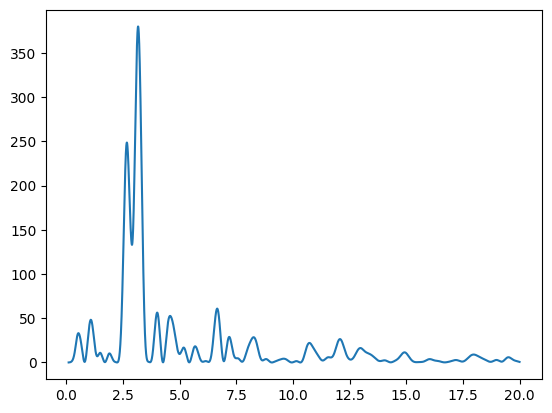

In [12]:
x_data = (np.sin(elevation_filtered*np.pi/180) * 4 * np.pi / WAVELENTH_S1).ravel()
y_data = snr1_ref.ravel()
w1 = np.linspace(0.1,20,10000)
power1 = signal.lombscargle(x_data,y_data,w1,normalize=True)
power1 = signal.lombscargle(x_data,y_data,w1)
plt.plot(w1,power1)


peaks,_= signal.find_peaks(power1)
#plt.plot(w[peaks],power[peaks])
peaks_power = power1[peaks]

h = w1[peaks]
print(h)
#h = h[peaks_power==max(peaks_power)] # the max
h = h[4] # the second max
print(h)
